## Importing Libraries

In [1]:
import numpy as np
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from tensorflow.keras.models  import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

In [2]:
dir_path = 'Garbage classification/'

In [3]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [4]:
len(img_list)

2527

# Image Augmentation

In [5]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [6]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

### Writing the labels file

In [7]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)


{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


# Using CNN and Saving Keras Model

In [8]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"

checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]



[Callback model Checkpoint Reference](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

# Summarizing our model

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43808)             0

### Compiling Model using categorical cross entropy loss function & Adam Optimizer

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

# Let's Train

In [11]:
history = model.fit_generator(train_generator,
                              epochs=5,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 2,
                              callbacks=callbacks_list) 

Epoch 1/5
70/71 [============================>.] - ETA: 4s - loss: 1.7398 - acc: 0.2410
Epoch 00001: val_acc improved from -inf to 0.29464, saving model to trained_model.h5
71/71 [==============================] - 348s 5s/step - loss: 1.7358 - acc: 0.2438 - val_loss: 1.5579 - val_acc: 0.2946
Epoch 2/5
70/71 [============================>.] - ETA: 4s - loss: 1.5229 - acc: 0.3679
Epoch 00002: val_acc improved from 0.29464 to 0.39286, saving model to trained_model.h5
71/71 [==============================] - 345s 5s/step - loss: 1.5210 - acc: 0.3676 - val_loss: 1.4494 - val_acc: 0.3929
Epoch 3/5
70/71 [============================>.] - ETA: 4s - loss: 1.4266 - acc: 0.3960
Epoch 00003: val_acc improved from 0.39286 to 0.41071, saving model to trained_model.h5
71/71 [==============================] - 343s 5s/step - loss: 1.4279 - acc: 0.3944 - val_loss: 1.3470 - val_acc: 0.4107
Epoch 4/5
70/71 [============================>.] - ETA: 4s - loss: 1.4409 - acc: 0.4033
Epoch 00004: val_acc did no

# Testing PREDICTION 
##### Note: Path is of training dataset (pl. don't mind)

Maximum Probability:  0.5902924
Classified: plastic


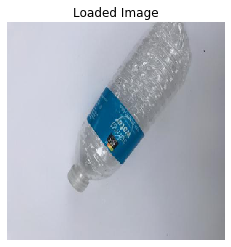

In [13]:
from tensorflow.keras.preprocessing import image

img_path = 'Garbage classification/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)




-------------------Individual Probability--------------------------------

CARDBOARD : 2.4 %
GLASS : 22.58 %
METAL : 11.61 %
PAPER : 4.0 %
PLASTIC : 59.03 %
TRASH : 0.38 %


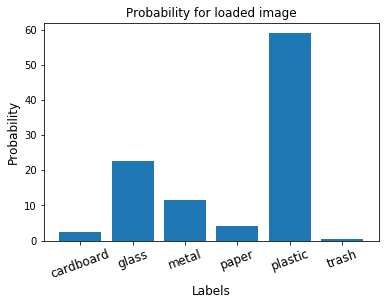

In [14]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

# Accuracy Graph

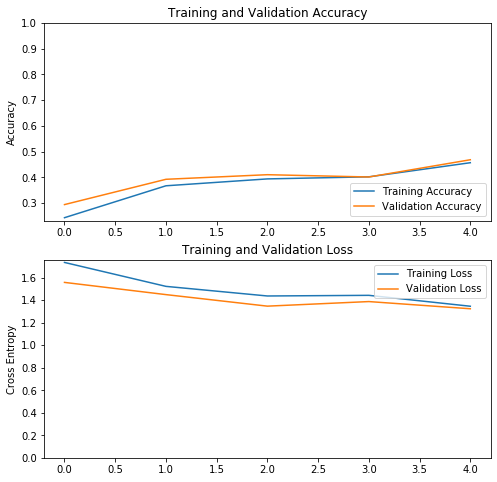

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()